# Find line for break in slope

## First find which RGT's were captured for which cycles

All of this information is dumped into a large dictionary

In [1]:
import os
import shapely as sp
import shapely.plotting as spplot
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time as Time
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak2 as slpbr
pd.options.mode.chained_assignment = None

/tmp/ipykernel_685/2381530074.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
allpaths = os.listdir("Saves")
rgts = sorted([int(path) for path in allpaths if "." not in list(path)])

In [3]:
names = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
cycles = list(range(1, 19))
directory = {rgt:{name:[] for name in names} for rgt in rgts}

In [4]:
for i, rgt in enumerate(rgts):
    for name in names:
        for cycle in cycles:
            filepath = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
            print(f"Checking paths for rgt: {rgt}-{name}-{cycle}", end="    \r")
            if os.path.isfile(filepath) == True:
                directory[rgt][name].append(cycle)

#
# Find Ib for each track in a given cycle

## First find which tracks are in that cycle

In [5]:
cycle = 11
fullset = []

In [6]:
for rgt in rgts:
    for name in names:
        if cycle in directory[rgt][name]:
            fullset.append(f"{rgt}-{name}")

## Prep other necessary items

In [7]:
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

In [8]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

## Open up and compute for each track

In [9]:
ibs = pd.DataFrame(columns=["x","y","time","cyc", "track", "qs", "px1", "py1", "px2", "py2"])

In [10]:
def find_near(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(idx)

In [11]:
def addon(track, ib, qs, plane, ibs):
    d_min = track["along_dist"].min() + 0.5
    d_max = track["along_dist"].max() - 0.5
    nearest_id = find_near(track["along_dist"], ib)
    xy = (track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"])
    time = track.iloc[nearest_id]["date_time"]
    if plane:
        nearest_id = find_near(track["along_dist"], plane[0])
        pxy1 = (track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"])
        nearest_id = find_near(track["along_dist"], plane[1])
        pxy2 = (track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"])
    else:
        pxy1, pxy2 = (None, None), (None, None)
    ibs.loc[-1] = {"x":xy[0], "y":xy[1], "time":time, "cyc":cycle, "track":item, "qs":qs, "px1":pxy1[0], "py1":pxy1[1], "px2":pxy2[0], "py2":pxy2[1]}  # adding a row
    ibs.index = ibs.index + 1  # shifting index
    ibs = ibs.sort_index()  # sorting by index
    return ibs

In [12]:
tot = len(fullset)
starttime = Time()
for i, item in enumerate(fullset):
    rgt, name = item.split("-")
    path = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
    print(f"{i}/{tot} ({round(i/tot*100, 2)}%) | Opening {rgt}-{name}-{cycle} | TotTime: {round((Time()-starttime)/60, 2)}min EstTime: {round(((Time()-starttime)/60) * (tot/(i+0.0001)) - (Time()-starttime)/60, 2)}min", end="        \r")
    track = gpd.read_file(path)
    print(f"{i}/{tot} ({round(i/tot*100, 2)}%) | Find Ib {rgt}-{name}-{cycle} | TotTime: {round((Time()-starttime)/60, 2)}min EstTime: {round(((Time()-starttime)/60) * (tot/(i+0.0001)) - (Time()-starttime)/60, 2)}min", end="        \r")
    out = slpbr.findIb(track, gline_xy)
    boolib = False
    try:
        track, ib, qs, plane = out
        if type(ib) != list:
            ibs = addon(track, ib, qs, plane, ibs)
        else:
            for i, q in zip(ib, qs):
                ibs = addon(track, i, q, plane, ibs)
        boolib = True
    except: 
        track = out

In [13]:
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
ibgpd = gpd.GeoDataFrame(ibs, geometry=gpd.points_from_xy(ibs["x"], ibs["y"]), crs=proj4_crs)

## Remove points far from others by calculating min dist to others

In [14]:
min_dists = []
for i, row in ibgpd.iterrows():
    rowdists = []
    x, y = row["x"], row["y"]
    for j, nrow in ibgpd.iterrows():
        if j != i:
            nx, ny = nrow["x"], nrow["y"]
            rowdists.append(((nx-x)**2+(ny-y)**2)**0.5)
    min_dists.append(min(rowdists))
ibgpd["min_dist"] = min_dists

In [15]:
ibgpd = ibgpd[ibgpd["min_dist"] < 10*1000]

## Calculate ice plain cheaply

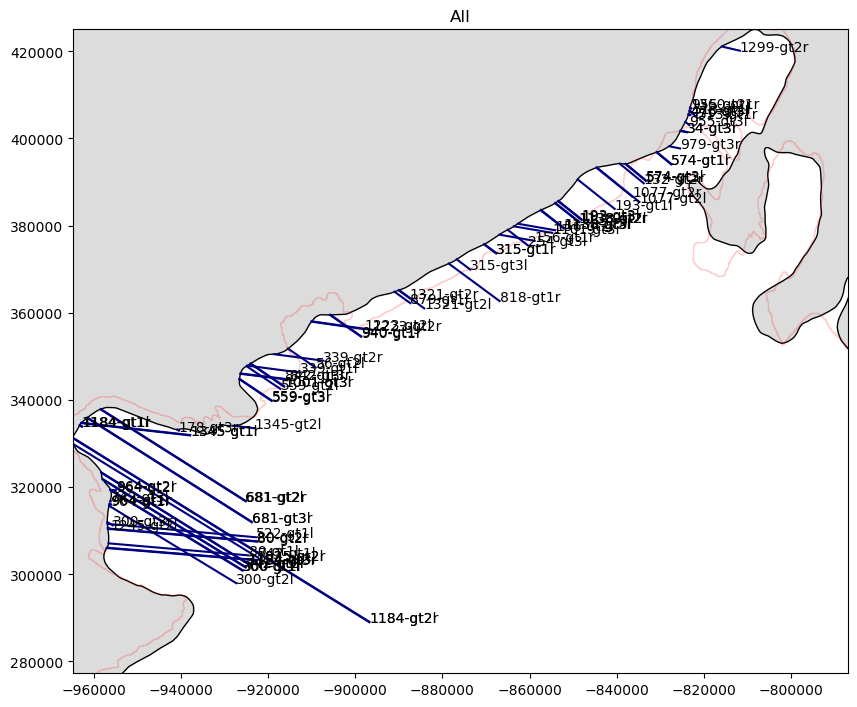

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

moa_gline = gpd.read_file("Line/moa_2009_groundingline_v02.0.shp")

for i, row in ibgpd.iterrows():
    if row["px1"]:
        
        # first check if point is within polygon.
        point = row.geometry
        if basemap.basemap_gpd.iloc[0].geometry.contains(point) == True:
            
            # create line which goes in rough track direction
            m = (row["py2"] - row["py1"]) / (row["px2"] - row["px1"])
            xysort = [row["px1"], row["px2"]], [row["py1"], row["py2"]]
            x0, x1 = xysort[0][0]-50000, xysort[0][1]+50000
            y0, y1 = m*(x0-xysort[0][0])+xysort[1][0], m*(x1-xysort[0][1])+xysort[1][1]
            
            line = sp.geometry.LineString([[x0, y0], [x1, y1]])
            intersect = sp.intersection(basemap.basemap_gpd.iloc[0].geometry.boundary, line)
            
            # check to ensure intersection is not endpoint of a line
            xs, ys = [], []
            if type(intersect) == sp.geometry.MultiPoint:
                min_dist, geom = 1e10, None
                for line in intersect.geoms:
                    new = line.xy
                    nxs, nys = list(new[0])[0], list(new[1])[0]
                    dist = ((row["x"] - nxs)**2 + (row["y"] - nys)**2)**0.5
                    if dist < min_dist:
                        min_dist = dist
                        geom = new
            else:
                geom = intersect.xy
                
            nxs, nys = list(geom[0]), list(geom[1])
            xs.extend(nxs)
            ys.extend(nys)
            
            # make into xy pairs and remove if equal to line endpoint
            pairs = [(x, y) for x, y in zip(xs, ys) if (x, y) != (x0, y0) or (x, y) != (x1, y1)]
                
            if xs:
                plt.plot([row["x"],pairs[0][0]], [row["y"],pairs[0][1]], c="navy")
                plt.text(row["x"], row["y"], row["track"])
                
moa_gline.plot(ax=ax, color="none", edgecolor="red", alpha= 0.2)
            
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

## Visualize

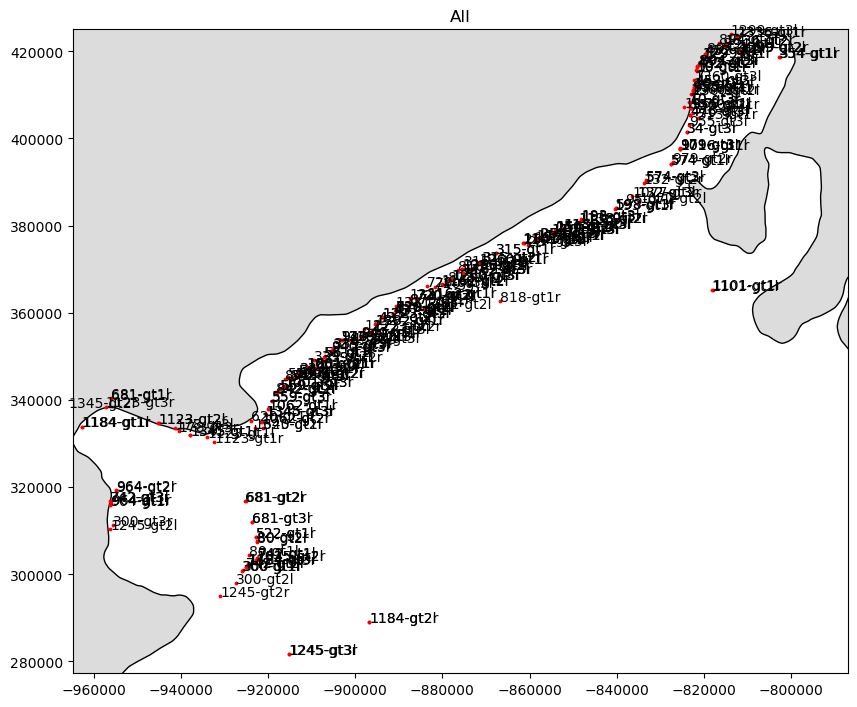

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
for i, row in ibgpd.iterrows():
    row = ibs.iloc[i]
    plt.scatter(row["x"], row["y"], s = 3, color="red")
    plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

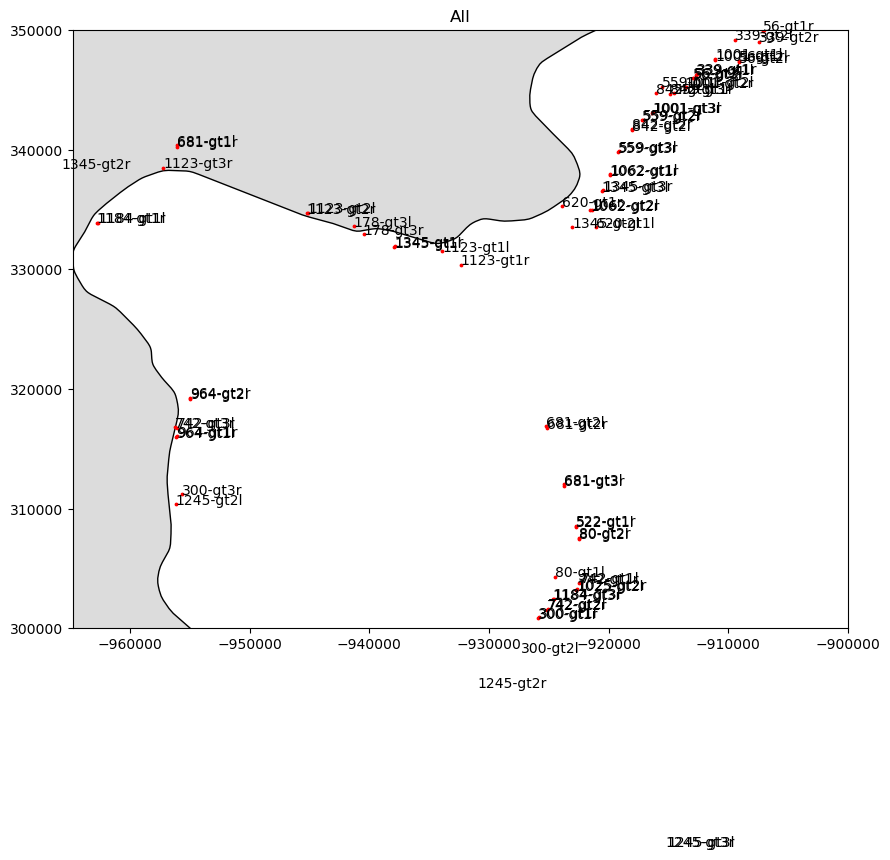

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20
 
ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
for i in range(len(ibs)):
    row = ibs.iloc[i]
    plt.scatter(row["x"], row["y"], s = 3, color="red")
    if row["x"] < -900000 and row["y"] < 350000:
        plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), -900000)
plt.ylim(300000, 350000)
    
plt.show()

In [19]:
ibgpd.to_csv(f"Line/{cycle}-Ib.csv")

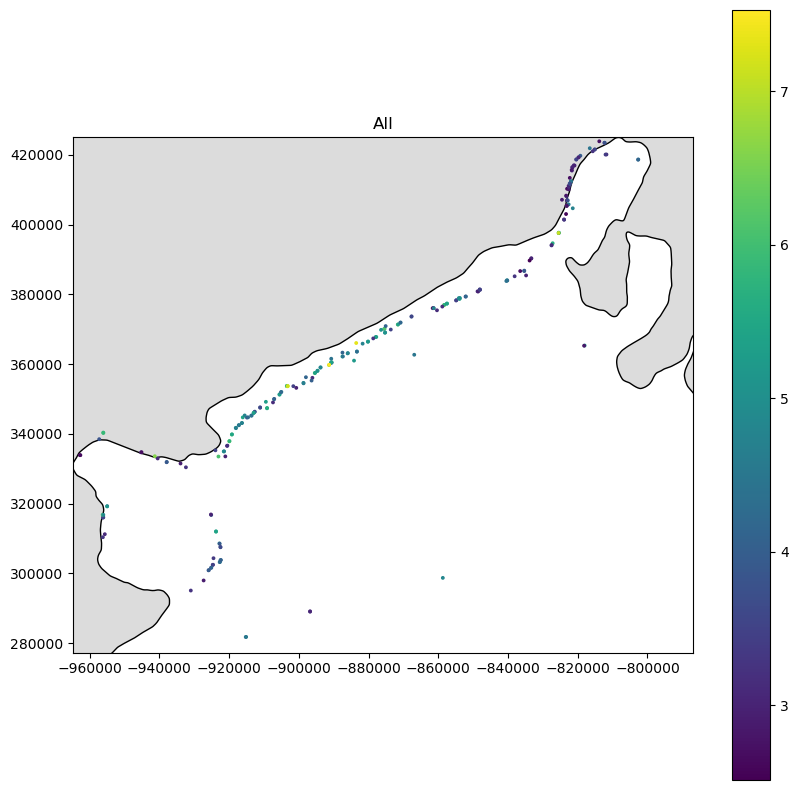

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
sc = plt.scatter(ibs["x"], ibs["y"], s = 3, c=ibs["qs"])
#sc = plt.scatter(ibs["x"], ibs["y"], s = 3, c=min_dists)
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
plt.colorbar(sc)
    
plt.show()

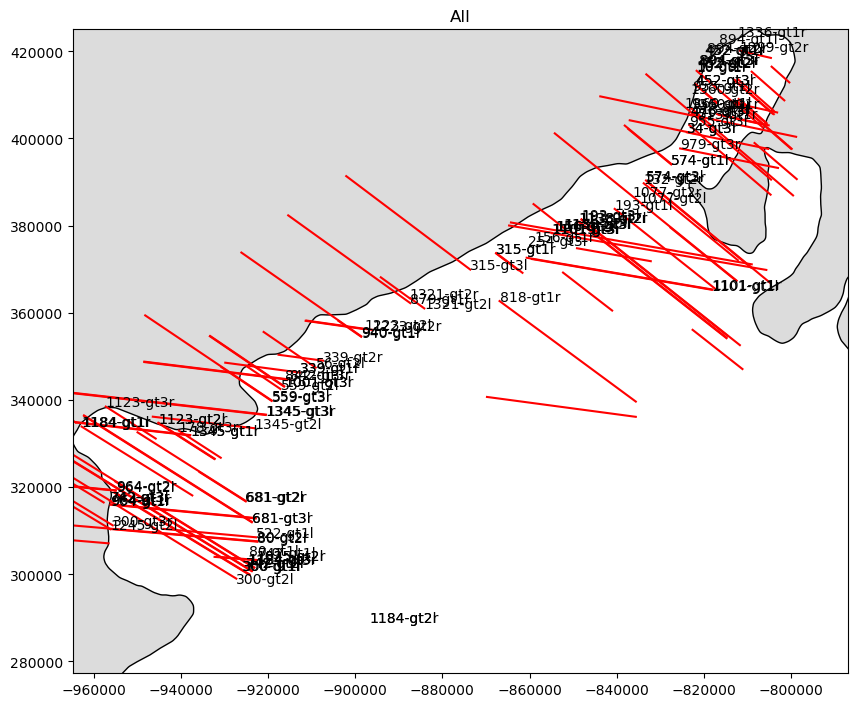

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
for i, row in ibgpd.iterrows():
    if row["px1"]:
        plt.plot([row["px1"], row["px2"]], [row[ "py1"], row["py2"]], c="red")
        plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()